##### set parent directory

In [1]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# Move to the parent directory
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

# Print the updated working directory
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Current Directory: /mnt/c/users/rjmay/code/research_ms/alt_distr
Updated Directory: /mnt/c/users/rjmay/code/research_ms


In [2]:
! source "../venv/bin/activate"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import pickle
import time



In [4]:
# from modules.multi_bounds_v3 import bounds_class
# # from modules.Bhatt_knn_func import knn_num_calc
# from modules.data_gen import data_gen

In [54]:
PICKLED =True

dim_str = "3" # TODO change me 


In [55]:
file_path = 'sim_data/normal_beta' + dim_str + '.pkl' # DONT FORGET TO CHANGE ME IF YOU COPY AND PASTE

    

if PICKLED == True:
    

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    bound_obj_lst, sample_sizes = loaded_objects

sample_sizes = sample_sizes *2

Loaded object successfully


### Using the data


In [56]:
dpi = 250

# sample_sizes = np.logspace(2, 3.3011, 9 , endpoint = True, dtype = int)

In [57]:
lst = [obj() for obj in bound_obj_lst ]

df = pd.DataFrame(lst, index = sample_sizes)

df.T


/home/rjmay/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rjmay/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,108,168,266,420,660,1038,1634,2570,4042,6358,10000
Dp_lower,0.115356,0.103890,0.091415,0.084356,0.078663,0.074552,0.071061,0.068565,0.066629,0.065847,0.064727
Dp_upper,0.202569,0.185298,0.165639,0.154208,0.144788,0.137868,0.131955,0.127685,0.124352,0.123006,0.121065
Bha_lower,0.035098,0.035420,0.035594,0.035535,0.035595,0.035539,0.035463,0.035548,0.035549,0.035583,0.035575
Bha_upper,0.183483,0.184504,0.185073,0.185000,0.185207,0.185082,0.184913,0.185138,0.185150,0.185239,0.185224
Bha_knn_lower,0.160561,0.203714,0.208820,0.227159,0.229926,0.236173,0.237603,0.237148,0.235605,0.234323,0.232456
Bha_knn_upper,0.363891,0.401056,0.405318,0.418304,0.420369,0.424454,0.425432,0.425228,0.424309,0.423527,0.422366
tight_lower,0.220574,0.266008,0.274527,0.295797,0.301757,0.310535,0.314131,0.315374,0.315201,0.314993,0.313837
tight_upper,0.228448,0.275282,0.284039,0.305891,0.312001,0.321004,0.324692,0.325974,0.325805,0.325604,0.324432
Maha_upper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inf_lower,0.045646,0.041220,0.038869,0.034785,0.037644,0.032416,0.033891,0.035174,0.031877,0.033326,0.033933


In [58]:
dp_l = []
dp_u = []

Bha_u =[]
Bha_l =[]

Bha_knn_u = []
Bha_knn_l = []

inf_l = []
inf_u = []

enDive_l = []
enDive_u = []


for obj in bound_obj_lst:
    a,b = obj.get_bounds_dp()
    dp_l.append(a)
    dp_u.append(b)
    
    a,b = obj.get_bounds_Bha()
    Bha_l.append(a)
    Bha_u.append(b)

    
#     a, b = obj.get_bounds_tight()
#     tight_l.append(a)
#     tight_u.append(b)
    
    a, b= obj.get_bounds_Bha_knn()
    Bha_knn_l.append(a)
    Bha_knn_u.append(b)
    
    a,b = obj.get_inf_bounds()
    inf_l.append(a)
    inf_u.append(b)
    
    a,b = obj.get_Bounds_enDive()
    enDive_l.append(a)
    enDive_u.append(b)
    
    

Calculate true values

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import beta
#### I have to code the true values and theoreticals. 

# Define dx and x range
dx = 0.001
x = np.arange(-10, 10 + dx, dx)

# Define the normal distributions
f0 = norm.pdf(x, loc=0, scale=1)
f1 = beta.pdf(x, a=20, b=20)

# Calculate the minimum of f0 and f1
min_f0_f1 = np.minimum(f0, f1)
# Calculate BER as 0.5 * sum(min(f0, f1) * dx)
BER = 0.5 * np.sum(min_f0_f1 * dx)

p = 0.5
q = 0.5
pf0 = p * f0
qf1 = q * f1

# Calculate the function
func = (pf0 - qf1)**2 / (pf0 + qf1)

# Calculate dp using numerical integration (sum and dx)
dp = np.nansum(func) * dx

# Calculate upper and lower bounds
upper = 0.5 - 0.5 * dp
lower = 0.5 - 0.5 * np.sqrt(dp)

theory_Dp = [lower, upper]

func2 = np.sqrt(f0 * f1)
# Calculate BC using numerical integration (sum and dx)
BC = np.nansum(func2) * dx

lower = 0.5 - 0.5 * np.sqrt(1 - BC**2)
upper = 0.5 * BC

theory_bha = [lower, upper]


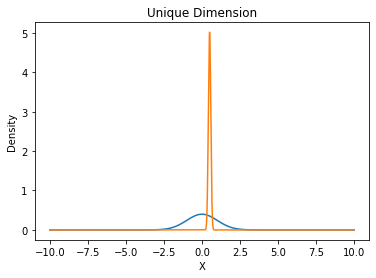

In [60]:
plt.plot(x, f0)
plt.plot(x, f1)
plt.title("Unique Dimension")
plt.xlabel("X")
plt.ylabel("Density")
plt.show()

In [61]:
theory_Dp

[0.06292977858379983, 0.11793924310238751]

In [62]:
BER

0.0726617598018901

True value is     0.07


In [63]:
### this cell helps to fix bugs from not doing the data in here. 
MC_num = len(bound_obj_lst[0])

BER_lst = np.ones(MC_num) * BER



def mse(l1, l2):## numpy lists
    return ((l1 - l2)**2).mean(axis=0)

In [64]:
# cases = len(sample_sizes)

## theoretical MSE
bha_theoretical_l= np.ones(MC_num) * (theory_bha[0])
bha_theoretical_u= np.ones(MC_num) * (theory_bha[1])


dp_theoretical_l= np.ones(MC_num) * theory_Dp[0]
dp_theoretical_u= np.ones(MC_num) * theory_Dp[1]


In [65]:
def mse_v2(true, matrix):
    temp = matrix - true
    temp = temp **2
    return np.mean(temp, axis= 1)
    

### Plotting

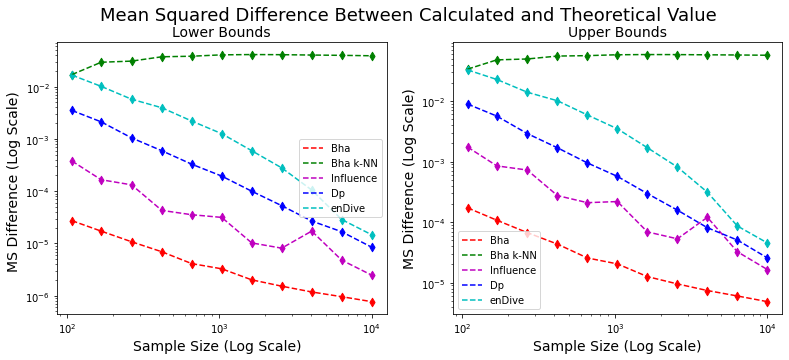

In [66]:
lower_mse_DP =mse_v2(theory_Dp[0], dp_l)
upper_mse_DP = mse_v2(theory_Dp[1], dp_u)

lower_mse_Bha = mse_v2(theory_bha[0], Bha_l)
upper_mse_Bha =mse_v2(theory_bha[1], Bha_u)


lower_mse_Bha_knn = mse_v2(theory_bha[0], Bha_knn_l)
upper_mse_Bha_knn =mse_v2(theory_bha[1], Bha_knn_u)

lower_mse_inf = mse_v2(theory_bha[0], inf_l)
upper_mse_inf = mse_v2(theory_bha[1], inf_u)

lower_mse_enDive = mse_v2(theory_Dp[0], enDive_l)
upper_mse_enDive = mse_v2(theory_Dp[1], enDive_u)


fs =14

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
st = fig.suptitle("Mean Squared Difference Between Calculated and Theoretical Value", fontsize=fs+4)
ax = axes[0]


ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, lower_mse_Bha,'r--', label='Bha')
ax.scatter(sample_sizes, lower_mse_Bha, color = 'red', marker = 'd')

ax.plot(sample_sizes, lower_mse_Bha_knn, color = 'green',linestyle="--",  label = "Bha k-NN")
ax.scatter(sample_sizes, lower_mse_Bha_knn, color = 'g', marker = 'd')

ax.plot(sample_sizes, lower_mse_inf,  'm--', label='Influence')
ax.scatter(sample_sizes, lower_mse_inf,  color='m', marker='d')

ax.plot(sample_sizes, lower_mse_DP,  'b--', label='Dp')
ax.scatter(sample_sizes, lower_mse_DP,  color='b', marker='d')


ax.plot(sample_sizes, lower_mse_enDive,  'c--', label='enDive')
ax.scatter(sample_sizes, lower_mse_enDive,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale) ", fontsize=fs)
ax.set_title("Lower Bounds", fontsize = fs)



ax.legend()

ax = axes[1]

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, upper_mse_Bha,'r--', label='Bha')
ax.scatter(sample_sizes, upper_mse_Bha, color = 'red', marker = 'd')


ax.plot(sample_sizes, upper_mse_Bha_knn, color = 'g',  linestyle  = "--", label = "Bha k-NN")
ax.scatter(sample_sizes, upper_mse_Bha_knn, color = 'g', marker = 'd')

ax.plot(sample_sizes, upper_mse_inf,  'm--', label='Influence')
ax.scatter(sample_sizes, upper_mse_inf,  color='m', marker='d')


ax.plot(sample_sizes, upper_mse_DP,  'b--', label='Dp')
ax.scatter(sample_sizes, upper_mse_DP,  color='b', marker='d')


ax.plot(sample_sizes, upper_mse_enDive,  'c--', label='enDive')
ax.scatter(sample_sizes, upper_mse_enDive,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale)", fontsize=fs)
ax.set_title("Upper Bounds", fontsize = fs)

ax.legend()



file_name = r"alt_distr/images/normal_beta_MSE" + dim_str+ ".png"
# plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= dpi)
plt.show()

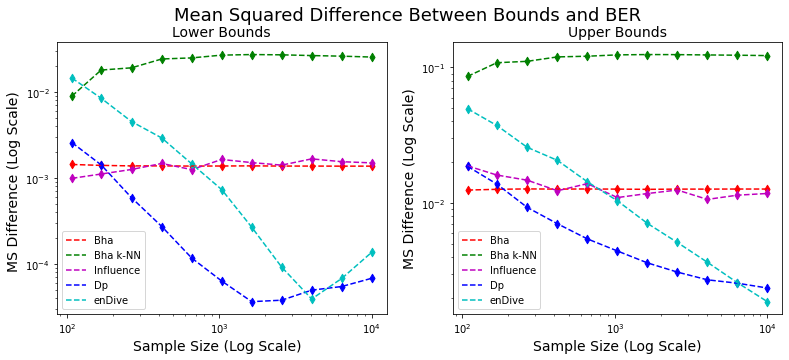

In [67]:
lower_mse_DP_BER =mse_v2(BER, dp_l)
upper_mse_DP_BER = mse_v2(BER, dp_u)

lower_mse_Bha_BER = mse_v2(BER, Bha_l)
upper_mse_Bha_BER =mse_v2(BER, Bha_u)


lower_mse_Bha_knn_BER = mse_v2(BER, Bha_knn_l)
upper_mse_Bha_knn_BER =mse_v2(BER, Bha_knn_u)

lower_mse_inf_BER = mse_v2(BER, inf_l)
upper_mse_inf_BER = mse_v2(BER, inf_u)

lower_mse_enDive_BER = mse_v2(BER, enDive_l)
upper_mse_enDive_BER = mse_v2(BER, enDive_u)

fs =14

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
st = fig.suptitle("Mean Squared Difference Between Bounds and BER", fontsize=fs+4)
ax = axes[0]


ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, lower_mse_Bha_BER,'r--', label='Bha')
ax.scatter(sample_sizes, lower_mse_Bha_BER, color = 'red', marker = 'd')

ax.plot(sample_sizes, lower_mse_Bha_knn_BER, color = 'green',linestyle="--",  label = "Bha k-NN")
ax.scatter(sample_sizes, lower_mse_Bha_knn_BER, color = 'g', marker = 'd')

ax.plot(sample_sizes, lower_mse_inf_BER,  'm--', label='Influence')
ax.scatter(sample_sizes, lower_mse_inf_BER,  color='m', marker='d')

ax.plot(sample_sizes, lower_mse_DP_BER,  'b--', label='Dp')
ax.scatter(sample_sizes, lower_mse_DP_BER,  color='b', marker='d')


ax.plot(sample_sizes, lower_mse_enDive_BER,  'c--', label='enDive')
ax.scatter(sample_sizes, lower_mse_enDive_BER,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale) ", fontsize=fs)
ax.set_title("Lower Bounds", fontsize = fs)


ax.legend()

ax = axes[1]

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, upper_mse_Bha_BER,'r--', label='Bha')
ax.scatter(sample_sizes, upper_mse_Bha_BER, color = 'red', marker = 'd')


ax.plot(sample_sizes, upper_mse_Bha_knn_BER, color = 'g',  linestyle  = "--", label = "Bha k-NN")
ax.scatter(sample_sizes, upper_mse_Bha_knn_BER, color = 'g', marker = 'd')

ax.plot(sample_sizes, upper_mse_inf_BER,  'm--', label='Influence')
ax.scatter(sample_sizes, upper_mse_inf_BER,  color='m', marker='d')


ax.plot(sample_sizes, upper_mse_DP_BER,  'b--', label='Dp')
ax.scatter(sample_sizes, upper_mse_DP_BER,  color='b', marker='d')


ax.plot(sample_sizes, upper_mse_enDive_BER,  'c--', label='enDive')
ax.scatter(sample_sizes, upper_mse_enDive_BER,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale)", fontsize=fs)
ax.set_title("Upper Bounds", fontsize = fs )

ax.legend()



file_name = r"alt_distr/images/normal_beta_MSE2" + dim_str+ ".png"
# plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= dpi)
plt.show()

Bhattacharyya, Bha Knn, influence same theoretically

Dp, enDive

In [68]:
BER

0.0726617598018901

In [69]:
lst = [obj.validity(BER) for obj in bound_obj_lst ]

# lst = [obj.experimental_validity() for obj in bound_obj_lst ]


df_valid = pd.DataFrame(lst, index = sample_sizes)

# df_valid


In [70]:
def add_noise_to_df(df, noise_level=0.01):
    """
    Add random noise to each column in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing the data to which noise will be added.
    
    Returns:
    - pandas DataFrame with noise added to each column.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_noisy = df.copy()
    
    # Iterate through each column in the DataFrame
    for col in df.columns:
        # Calculate the range of the data in the column
#         data_range = df[col].max() - df[col].min()
        
        # Generate random noise from a normal distribution
#         noise = np.random.normal(0, noise_level * data_range, len(df[col]))
        noise = np.random.normal(0, noise_level )
#         noise = np.random.uniform(-1 * noise_level, noise_level)
        # Add the noise to the data in the column
        df_noisy[col] = df[col] + noise
    
    return df_noisy


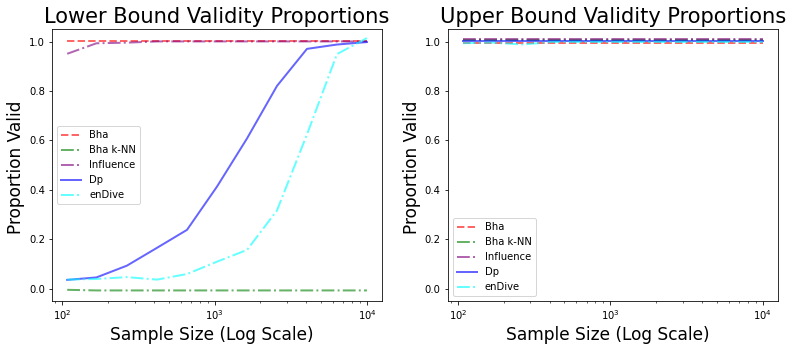

In [71]:
df_noise = add_noise_to_df(df_valid, .008)

fs =17
overlapping = 0.6
lw = 2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

ax = axes[0]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(df_noise["Bha_lower"],'r--', label='Bha', alpha = overlapping, linewidth=lw )

ax.plot(df_noise["Bha_knn_lower"],'g-.', label='Bha k-NN', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["inf_lower"],'purple',ls = "-.", label='Influence', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["Dp_lower"], 'b-',  label='Dp', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["enDive_lower"],'cyan',ls = "-.", label='enDive', alpha = overlapping, linewidth = lw)


# ax.plot(df_valid["tight_lower"],'orange', label='Tight  ')


# ax.plot(sample_sizes, validity_tight_u/ MC_num,  label='Upper Tight Validity ')
# ax.set_xticks(sample_sizes)
ax.set_ylim(-0.05,1.05)
ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion Valid ", fontsize=fs)
ax.set_title("Lower Bound Validity Proportions" , fontsize = fs +4)
ax.legend()


ax = axes[1]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(df_noise["Bha_upper"],'r--', label='Bha', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["Bha_knn_upper"],'g-.', label='Bha k-NN', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["inf_upper"],'purple',ls = "-.", label='Influence', alpha = overlapping, linewidth =lw)

ax.plot(df_noise["Dp_upper"], 'b-',  label='Dp', alpha = overlapping, linewidth = lw)

ax.plot(df_noise["enDive_upper"],'cyan',ls = "-.", label='enDive', alpha = overlapping, linewidth = lw)


# ax.set_xticks(sample_sizes)
ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion Valid ", fontsize=fs)
ax.set_ylim(-0.05,1.05)
ax.set_title("Upper Bound Validity Proportions" , fontsize = fs +4)
ax.legend()

# plt.subplots_adjust(left=0.05, right=0.96, bottom=0.1, top=0.90)


file_name = r"alt_distr/images/normal_beta_validity" + dim_str+".png"
# plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= dpi)
plt.show()

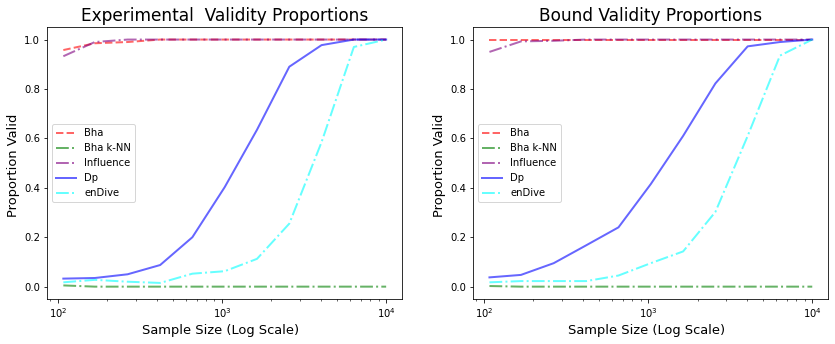

In [72]:


fs =13

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax = axes[1]
ax1 = ax

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(df_valid["Bha"],'r--', label='Bha', alpha = overlapping, linewidth=lw )
ax.plot(df_valid["Bha_knn"],'g-.', label='Bha k-NN', alpha = overlapping, linewidth = lw)
ax.plot(df_valid["inf"],'purple',ls = "-.", label='Influence', alpha = overlapping, linewidth = lw)
ax.plot(df_valid["Dp"], 'b-',  label='Dp', alpha = overlapping, linewidth = lw)
ax.plot(df_valid["enDive"],'cyan',ls = "-.", label='enDive', alpha = overlapping, linewidth = lw)

# ax.set_xticks(sample_sizes)
ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion Valid ", fontsize=fs)
ax.set_ylim(-0.05,1.05)
ax.set_title("Bound Validity Proportions" , fontsize = fs +4)
ax.legend()





lst = [obj.experimental_validity() for obj in bound_obj_lst ]


df_valid2 = pd.DataFrame(lst, index = sample_sizes)

ax = axes[0]

# df_noise2 = add_noise_to_df(df_valid2, .008)


ax = axes[0]
ax1 = ax

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(df_valid2["Bha"],'r--', label='Bha', alpha = overlapping, linewidth=lw )
ax.plot(df_valid2["Bha_knn"],'g-.', label='Bha k-NN', alpha = overlapping, linewidth = lw)
ax.plot(df_valid2["inf"],'purple',ls = "-.", label='Influence', alpha = overlapping, linewidth = lw)
ax.plot(df_valid2["Dp"], 'b-',  label='Dp', alpha = overlapping, linewidth = lw)
ax.plot(df_valid2["enDive"],'cyan',ls = "-.", label='enDive', alpha = overlapping, linewidth = lw)

# ax.set_xticks(sample_sizes)
ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion Valid ", fontsize=fs)
ax.set_ylim(-0.05,1.05)
ax.set_title("Experimental  Validity Proportions" , fontsize = fs +4)
ax.legend()

plt.show()


In [73]:
df_valid.columns

Index(['Dp_lower', 'Dp_upper', 'Bha_lower', 'Bha_upper', 'Bha_knn_lower',
       'Bha_knn_upper', 'tight_lower', 'tight_upper', 'inf_lower', 'inf_upper',
       'enDive_lower', 'enDive_upper', 'Dp', 'Bha', 'Bha_knn', 'tight', 'inf',
       'enDive'],
      dtype='object')

In [74]:
df_valid_some =df_valid[['Dp', 'Bha',
       'Bha_knn', 'tight', 'inf', 'enDive']]

df_valid_some

,Dp,Bha,Bha_knn,tight,inf,enDive
108,0.0375,1.0,0.0025,0.0,0.9500,0.0175
168,0.0475,1.0,0.0000,0.0,0.9925,0.0225
266,0.0950,1.0,0.0000,0.0,0.9950,0.0225
420,0.1675,1.0,0.0000,0.0,1.0000,0.0225
660,0.2400,1.0,0.0000,0.0,1.0000,0.0450
1038,0.4150,1.0,0.0000,0.0,1.0000,0.0950
1634,0.6100,1.0,0.0000,0.0,1.0000,0.1425
2570,0.8225,1.0,0.0000,0.0,1.0000,0.3025
4042,0.9725,1.0,0.0000,0.0,1.0000,0.6100
6358,0.9900,1.0,0.0000,0.0,1.0000,0.9350


In [75]:
df_valid2

,Dp,Bha,Bha_knn,tight,inf,enDive
108,0.0325,0.9575,0.005,0.0,0.9325,0.0175
168,0.0350,0.9850,0.000,0.0,0.9900,0.0275
266,0.0500,0.9900,0.000,0.0,1.0000,0.0200
420,0.0875,1.0000,0.000,0.0,1.0000,0.0150
660,0.2000,1.0000,0.000,0.0,1.0000,0.0525
1038,0.4025,1.0000,0.000,0.0,1.0000,0.0625
1634,0.6350,1.0000,0.000,0.0,1.0000,0.1125
2570,0.8900,1.0000,0.000,0.0,1.0000,0.2550
4042,0.9775,1.0000,0.000,0.0,1.0000,0.5850
6358,1.0000,1.0000,0.000,0.0,1.0000,0.9700


### Master Figure


In [76]:
lst = [obj.bound_width() for obj in bound_obj_lst ]

bound_width_df = pd.DataFrame(lst, index = sample_sizes)

bound_width_df.head()

,Dp,Bha,Bha_knn,tight,inf,enDive
108,0.087213,0.148386,0.203329,0.007873,0.159361,0.106139
168,0.081408,0.149084,0.197343,0.009275,0.155563,0.102656
266,0.074225,0.149480,0.196498,0.009512,0.152383,0.094238
420,0.069852,0.149465,0.191145,0.010094,0.147585,0.090438
660,0.066125,0.149613,0.190443,0.010244,0.152173,0.082697


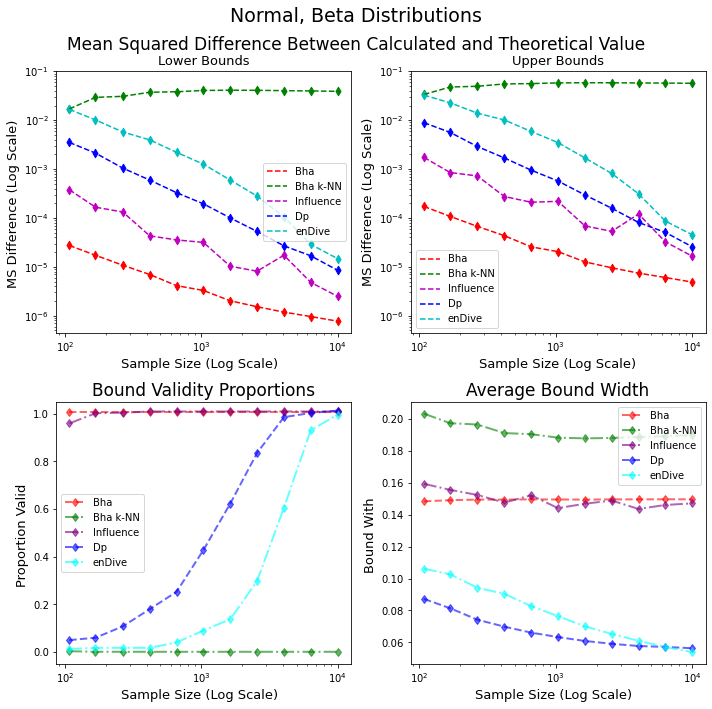

In [77]:

fs =13

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
st = fig.suptitle("Normal, Beta Distributions", fontsize=fs+6)

fig.text(0.5, 0.92, "Mean Squared Difference Between Calculated and Theoretical Value", ha='center', fontsize=fs+4 )

# Manually share y-axis between axes[0][0] and axes[0][1]
axes[0][1].get_shared_y_axes().join(axes[0][0], axes[0][1])


ax = axes[0][0]


ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, lower_mse_Bha,'r--', label='Bha')
ax.scatter(sample_sizes, lower_mse_Bha, color = 'red', marker = 'd')

ax.plot(sample_sizes, lower_mse_Bha_knn, color = 'green',linestyle="--",  label = "Bha k-NN")
ax.scatter(sample_sizes, lower_mse_Bha_knn, color = 'g', marker = 'd')

ax.plot(sample_sizes, lower_mse_inf,  'm--', label='Influence')
ax.scatter(sample_sizes, lower_mse_inf,  color='m', marker='d')

ax.plot(sample_sizes, lower_mse_DP,  'b--', label='Dp')
ax.scatter(sample_sizes, lower_mse_DP,  color='b', marker='d')


ax.plot(sample_sizes, lower_mse_enDive,  'c--', label='enDive')
ax.scatter(sample_sizes, lower_mse_enDive,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale) ", fontsize=fs)
ax.set_title("Lower Bounds", fontsize = fs)



ax.legend()

ax = axes[0][1]

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, upper_mse_Bha,'r--', label='Bha')
ax.scatter(sample_sizes, upper_mse_Bha, color = 'red', marker = 'd')


ax.plot(sample_sizes, upper_mse_Bha_knn, color = 'g',  linestyle  = "--", label = "Bha k-NN")
ax.scatter(sample_sizes, upper_mse_Bha_knn, color = 'g', marker = 'd')

ax.plot(sample_sizes, upper_mse_inf,  'm--', label='Influence')
ax.scatter(sample_sizes, upper_mse_inf,  color='m', marker='d')


ax.plot(sample_sizes, upper_mse_DP,  'b--', label='Dp')
ax.scatter(sample_sizes, upper_mse_DP,  color='b', marker='d')


ax.plot(sample_sizes, upper_mse_enDive,  'c--', label='enDive')
ax.scatter(sample_sizes, upper_mse_enDive,  color='c', marker='d')

ax.set_xlabel("Sample Size (Log Scale)", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale)", fontsize=fs)
ax.set_title("Upper Bounds", fontsize = fs)
ax.legend()



ax = axes[1][0]
ax1 = ax

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)



ax.plot(df_noise["Bha"], 'r--d', label='Bha', alpha=overlapping, linewidth=lw)
ax.plot(df_noise["Bha_knn"], 'g-.d', label='Bha k-NN', alpha=overlapping, linewidth=lw)
ax.plot(df_noise["inf"], color='purple', linestyle='-.', marker='d', label='Influence', alpha=overlapping, linewidth=lw)
ax.plot(df_noise["Dp"], 'b--d', label='Dp', alpha=overlapping, linewidth=lw)
ax.plot(df_noise["enDive"], color = 'cyan', linestyle='-.', marker ='d', label='enDive', alpha=overlapping, linewidth=lw)


# ax.set_xticks(sample_sizes)
ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion Valid ", fontsize=fs)
ax.set_ylim(-0.05,1.05)
ax.set_title("Bound Validity Proportions" , fontsize = fs +4)
ax.legend()


ax = axes[1][1]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(bound_width_df["Bha"],'r--d', label='Bha', alpha = overlapping, linewidth=lw )
ax.plot(bound_width_df["Bha_knn"],'g-.d', label='Bha k-NN', alpha = overlapping, linewidth = lw)
ax.plot(bound_width_df["inf"],color = 'purple',ls = "-.", marker= 'd', label='Influence', alpha = overlapping, linewidth = lw)
ax.plot(bound_width_df["Dp"], 'b--d',  label='Dp', alpha = overlapping, linewidth = lw)
ax.plot(bound_width_df["enDive"],color = 'cyan',ls = "-.", marker = 'd',label='enDive', alpha = overlapping, linewidth = lw)

# ax.set_xticks(sample_sizes)
ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Bound With ", fontsize=fs)
# ax.set_ylim(0.0, 0.3)
ax.set_title("Average Bound Width" , fontsize = fs +4)
ax.legend()



fig.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the common title



file_name = r"alt_distr/images/normal_beta_master" + dim_str + ".png"
plt.savefig(file_name,facecolor=(1,1,1,1),  bbox_inches='tight', dpi= dpi)
plt.show()